# Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt    
%matplotlib inline
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn import L1Loss, MSELoss
from itertools import chain
import pickle

In [2]:
!nvidia-smi

Sun Jan 30 09:22:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
image_size = 256
batch_size = 1
buffer_size = 50
n_epochs = 200
dir_train_A = '/content/w2p_new/trainA'
dir_train_B = '/content/w2p_new/trainB'
dir_test_A = '/content/w2p_new/testA'
dir_test_B = '/content/w2p_new/testB'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
'''
Класс для пар картинок
Если изображений одного типа больше, то в пару к ним ставятся случайные
'''
class paired_dataset(Dataset):
    def __init__(self,dir_A,dir_B,transforms = None):
        self.dir_A = dir_A
        self.dir_B = dir_B
        self.transforms = transforms
        self.data_A = []
        self.data_B = []
        for _, _, images_list in os.walk(self.dir_A):
            for image_name in images_list:
                if image_name.endswith(".jpg") or image_name.endswith(".png") or image_name.endswith(".jpeg"):
                    self.data_A.append(image_name)
        for _, _, images_list in os.walk(self.dir_B):
            for image_name in images_list:
                if image_name.endswith(".jpg") or image_name.endswith(".png") or image_name.endswith(".jpeg"):
                    self.data_B.append(image_name)
        self.data_A = sorted(self.data_A)#Для проверки модели я использую датасет facades. 
        self.data_B = sorted(self.data_B)#Возможно качество на нем немного улучшается если подавать правильные пары(фотографию и разметку)
    def __getitem__(self,index):
        idxA = index
        idxB = index
        if index >= len(self.data_A):
            idxA = np.random.randint(len(self.data_A)) 
        elif index >= len(self.data_B):
            idxB = np.random.randint(len(self.data_B)) 
        path_A = os.path.join(self.dir_A,self.data_A[idxA])
        path_B = os.path.join(self.dir_B,self.data_B[idxB])
        image_A = Image.open(path_A).convert('RGB')#there are some black and white images
        image_B = Image.open(path_B).convert('RGB')
        if self.transforms:
            image_A = self.transforms(image_A)
            image_B = self.transforms(image_B)
        return image_A,image_B
    def __len__(self):
        return max(len(self.data_A),len(self.data_B))

In [7]:
'''
Класс для пар картинок
Если изображений одного типа больше, то в пару к ним ставятся случайные
Эта версия загружает данные сразу на gpu
'''
class paired_dataset_updated(Dataset):
    def __init__(self,dir_A,dir_B,transforms = None,requires_flip = True):
        self.dir_A = dir_A
        self.dir_B = dir_B
        self.transforms = transforms
        self.data_A = []
        self.data_B = []
        self.listed_A = []
        self.listed_B = []
        self.requires_flip = requires_flip
        for _, _, images_list in os.walk(self.dir_A):
            for image_name in images_list:
                if image_name.endswith(".jpg") or image_name.endswith(".png") or image_name.endswith(".jpeg"):
                    self.data_A.append(image_name)
        for _, _, images_list in os.walk(self.dir_B):
            for image_name in images_list:
                if image_name.endswith(".jpg") or image_name.endswith(".png") or image_name.endswith(".jpeg"):
                    self.data_B.append(image_name)
        self.data_A = sorted(self.data_A)#Для проверки модели я использую датасет facades. 
        self.data_B = sorted(self.data_B)#Возможно качество на нем немного улучшается если подавать правильные пары(фотографию и разметку)
        for path_img in self.data_A:
            path_A = os.path.join(self.dir_A,path_img)
            image = Image.open(path_A).convert('RGB')
            image = self.transforms(image)
            image = image.to(device)
            self.listed_A.append(image)
        for path_img in self.data_B:
            path_B = os.path.join(self.dir_B,path_img)
            image = Image.open(path_B).convert('RGB')
            image = self.transforms(image)
            image = image.to(device)
            self.listed_B.append(image)
    def __getitem__(self,index):
        idxA = index
        idxB = index
        if index >= len(self.data_A):
            idxA = np.random.randint(len(self.data_A)) 
        elif index >= len(self.data_B):
            idxB = np.random.randint(len(self.data_B)) 
        image_A = self.listed_A[idxA]
        image_B = self.listed_B[idxB]
        if self.requires_flip:
            image_A = tt.RandomHorizontalFlip(p = 0.5)(image_A)
            image_B = tt.RandomHorizontalFlip(p = 0.5)(image_B)
        return image_A,image_B
    def __len__(self):
        return max(len(self.data_A),len(self.data_B))

In [8]:
def pr_to_plot(norm_img):
    return np.rollaxis(norm_img.numpy()*0.5+0.5, 0, 3)

In [9]:
#weights initialization like https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#weight-initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Dataset preprocessing

In [ ]:
#!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/mini.zip
#!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/facades.zip
#!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
#!gdown --id 1FuEF1VWoncq27b8_ZOGqf4xkN5c1Zz8Z
#!unzip mini.zip
#!unzip facades.zip
#!unzip horse2zebra.zip
#!unzip /content/w2p_new.zip

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
default_transforms = tt.Compose([tt.Resize(image_size),
                     tt.CenterCrop(image_size), 
                     tt.ToTensor(),
                     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ])

In [14]:
#dataset = paired_dataset(dir_train_A,dir_train_B,transform_train)
dataset = paired_dataset_updated(dir_train_A,dir_train_B,default_transforms,requires_flip=True)                         
dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = True)

In [15]:
dataset.__len__()

709

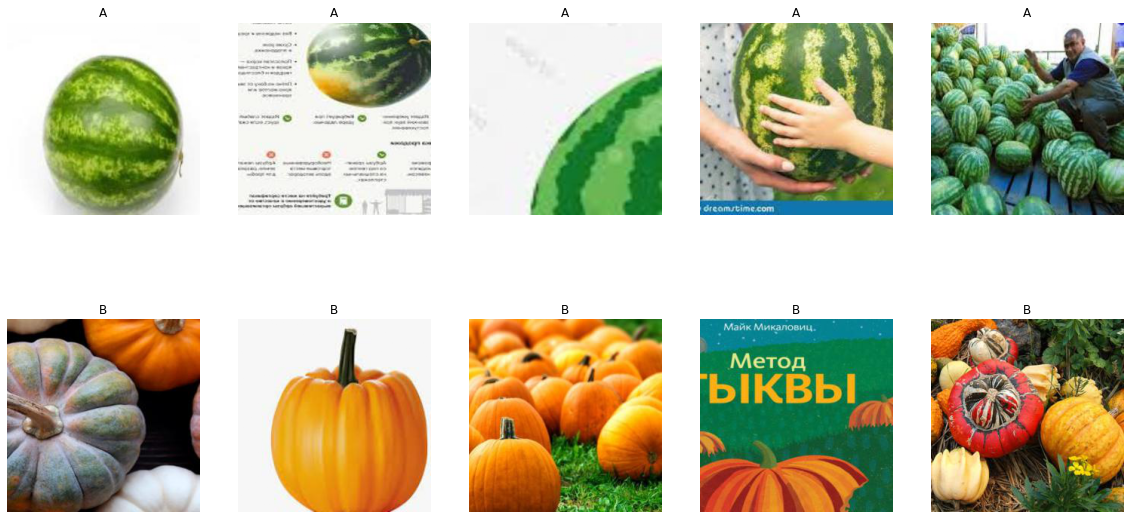

In [16]:
n_pairs = 5
plt.figure(figsize=(n_pairs*4, n_pairs*2))
for i in range(n_pairs):
    plt.subplot(2, n_pairs, i+1)
    plt.title('A')
    plt.imshow(pr_to_plot(dataset[i][0].cpu()))
    plt.axis('off')
    plt.subplot(2, n_pairs, i+n_pairs+1)
    plt.title('B')
    plt.imshow(pr_to_plot(dataset[i][1].cpu()))
    plt.axis('off')

# Models

In [1]:
#Буфер сделан и работает только для batch_size = 1
buffer_size = 50
class buffer():
    def __init__(self):
        self.size = buffer_size
        self.history = []
    def get_image(self,image):
        if len(self.history) < self.size:
            self.history.append(image)
            res = image
        else:
            p = np.random.uniform(0,1)
            if p > 0.5:
                idx = np.random.randint(0,self.size)
                res = self.history[idx]
                self.history[idx] = image
            else:
                res = image
        return res
    def get_buffer(self):
        return self.history

## Discriminator

В статье https://arxiv.org/abs/1703.10593 используется PatchGAN в качестве дискриминатора. Его архитектура имеет виде C64 - C128 - C256 - C512 - Conv(out_channels = 1) - Sigmoid, где  Ck - Conv(in_channels, out_channels = k, kernel_size = 4х4, stride = 2) - InstanceNorm - LeakyRelu(0.2).<br>Везде, где необходимо используется reflection padding. В первом слое InstanceNorm отсутствует. В соответсвии со статьей о pix2pix (https://arxiv.org/abs/1611.07004) каждый слой делает downsampling в два раза.<br> В оригинальной реализации в С512 используется stride = 1, я делаю так-же.<br>
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39<br>
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/162<br>

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.C64 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 4, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.LeakyReLU(0.2,inplace = True),
        )
        self.C128 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 4, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2,inplace = True),
        )
        self.C256 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 4, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2,inplace = True),
        )
        self.C512 = nn.Sequential(
            nn.Conv2d(in_channels = 256,out_channels = 512,kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2,inplace = True),
        )
        self.out = nn.Sequential(
            nn.Conv2d(in_channels = 512, out_channels = 1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect'),
            #nn.Sigmoid() - не используется из-за MSELoss - https://arxiv.org/abs/1611.04076
        )
    def forward(self,x):
        x = self.C64(x)
        x = self.C128(x)
        x = self.C256(x)
        x = self.C512(x)
        x = self.out(x)
        return x

## Generator

In [19]:
class R256_block(nn.Module):
    def __init__(self):
        super().__init__()
        self.R = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
        )
    def forward(self,x):
        return x+self.R(x)#Тут сделано как в гитхабе авторов оригинальной статьи т.е. как в resnet

Для избавления от артефактов вместо ConvTransposed используется Upsample+ReflectionPad+Conv2d<br> 
В Upsample mode = nearest<br>
https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/190#issuecomment-358546675<br>
https://distill.pub/2016/deconv-checkerboard/<br>

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.c7s164 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace = True),
        )
        self.d128 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace = True),
        )
        self.d256 = nn.Sequential(
            nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace = True),
        )
        resnet = []
        for i in range(9):
            resnet.append(R256_block())
        self.R256x9 = nn.Sequential(*resnet)
        self.u128 = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace = True),
        )
        self.u64 = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace = True),
        )
        self.c7s13 = nn.Sequential(
            nn.Conv2d(in_channels = 64,out_channels = 3,kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'),
        )
    def forward(self,x):
        x = self.c7s164(x)
        x = self.d128(x)
        x = self.d256(x)
        x = self.R256x9(x)
        x = self.u128(x)
        x = self.u64(x)
        x = self.c7s13(x)
        return torch.tanh(x)

# Training

In [21]:
learning_rate = 0.0002
lam = 10.0
#id_map = 0.5*lam
#id_loss = L1Loss() #for my datasets it's not necessary

In [22]:
def Loss_Gen(G,F,Dx,Dy,real_image_A,real_image_B,fake_image_A,fake_image_B,gan_loss,cycle_loss):#,id_loss):
    fake_preds_A = Dx(fake_image_A)
    fake_preds_B = Dy(fake_image_B)
    L_gan_F = gan_loss(fake_preds_A, torch.ones_like(fake_preds_A))
    L_gan_G = gan_loss(fake_preds_B, torch.ones_like(fake_preds_B))
    recon_A = F(fake_image_B)
    recon_B = G(fake_image_A)
    rec_real_A = F(real_image_A)
    return L_gan_G+L_gan_F+(L_cyc_G+L_cyc_F)*lam

In [23]:
def Loss_Disc(D,real_image,fake_image,loss,buffer):
    
    real_preds = D(real_image)
    real_loss = loss(real_preds, torch.ones_like(real_preds))           
    fake_image = buffer.get_image(fake_image.detach())
    fake_preds = D(fake_image)
    fake_loss = loss(fake_preds, torch.zeros_like(fake_preds))

    return real_loss + fake_loss

In [24]:
'''
lr постоянен первые 100 эпох, затем линейно убывает до нуля
'''
def func2(epoch):
    if epoch<=100:
        return 1.0
    else:
        return np.linspace(0.0002,0,100)[epoch-101]/0.0002

In [25]:
gan_loss = MSELoss()
cycle_loss = L1Loss()
buffer_a = buffer()
buffer_b = buffer()

In [26]:
Dx = Discriminator().to(device)#x and F(y) X == A Y == B 
Dy = Discriminator().to(device)#y and G(x)
G = Generator().to(device)#G:X->Y
F = Generator().to(device)#F:Y->X

In [27]:
Dx.apply(weights_init)
Dy.apply(weights_init)
G.apply(weights_init)
F.apply(weights_init)
print('silence')

silence


In [33]:
optimizer_D = torch.optim.Adam(chain(Dx.parameters(),Dy.parameters()),lr=learning_rate,betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(chain(G.parameters(),F.parameters()),lr=learning_rate,betas=(0.5, 0.999))
"""
Ипользуется именно такой вид т.к. для иначе придется либо иметь отдельный лосс для кажого случая, 
либо следить за сохранением графов вычислений
"""

In [34]:
G.load_state_dict(torch.load('/content/drive/MyDrive/gen_G'))
F.load_state_dict(torch.load('/content/drive/MyDrive/gen_F'))
Dx.load_state_dict(torch.load('/content/drive/MyDrive/disc_Dx'))
Dy.load_state_dict(torch.load('/content/drive/MyDrive/disc_Dy'))
optimizer_D.load_state_dict(torch.load('/content/drive/MyDrive/opt_D'))
optimizer_G.load_state_dict(torch.load('/content/drive/MyDrive/opt_G'))

In [35]:
sch_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G,func2,last_epoch=-1)
sch_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D,func2,last_epoch=-1)

In [ ]:
Generators_loss = []
Discriminators_loss = []
'''
Лоссы состоят из сумм лоссов генераторов и дискриминаторов
Я не делаю перевод модели в train/eval, т.к. это не влияет на их поведение(и на InstanceNorm в данном случае тоже)
Изображения уже загружены на gpu paired_dataset_updated(), это немного ускоряет обучение
Если данные не помещаются в память, то необходимо использовать paired_dataset()
'''
for epoch in range(n_epochs):
    Generators_loss_per_epoch = []
    Discriminators_loss_per_epoch = []
    for img_A,img_B in tqdm(dataloader):
        #img_A = img_A.to(device)
        #img_B = img_B.to(device)
        fake_A = F(img_B)
        fake_B = G(img_A)
        Loss_Dxy = 1.0/2.0*(Loss_Disc(Dx,img_A,fake_A,gan_loss,buffer_a)+
                        Loss_Disc(Dy,img_B,fake_B,gan_loss,buffer_b))
        optimizer_D.zero_grad()
        Loss_Dxy.backward()
        optimizer_D.step()

        Loss_GF = Loss_Gen(G,F,Dx,Dy,img_A,img_B,fake_A,fake_B,gan_loss,cycle_loss)
        optimizer_G.zero_grad()
        Loss_GF.backward()
        optimizer_G.step()
        Discriminators_loss_per_epoch.append(Loss_Dxy.detach().cpu())
        Generators_loss_per_epoch.append(Loss_GF.detach().cpu())
        #img_A = img_A.detach().cpu()
        #img_B = img_B.detach().cpu()
        torch.cuda.empty_cache()
    sch_G.step()
    sch_D.step()
    if epoch%10 == 0:
        torch.save(G.state_dict(),'/content/drive/MyDrive/gen_G')
        torch.save(F.state_dict(),'/content/drive/MyDrive/gen_F')
        torch.save(Dx.state_dict(),'/content/drive/MyDrive/disc_Dx')
        torch.save(Dy.state_dict(),'/content/drive/MyDrive/disc_Dy')
        torch.save(optimizer_D.state_dict(),'/content/drive/MyDrive/opt_D')
        torch.save(optimizer_G.state_dict(),'/content/drive/MyDrive/opt_G')
    Discriminators_loss.append(np.mean(Discriminators_loss_per_epoch))
    Generators_loss.append(np.mean(Generators_loss_per_epoch))
    print("Generators_loss = %f, Discriminators_loss = %f,epoch = %i, learning_rate = %f" 
          %(Generators_loss[-1],Discriminators_loss[-1],epoch+1,sch_D.get_last_lr()[0]))

# Validation

In [42]:
# torch.save(G.state_dict(),'/content/drive/MyDrive/w2p_new_200_G')
# torch.save(F.state_dict(),'/content/drive/MyDrive/w2p_new_200_F')
# torch.save(Dx.state_dict(),'/content/drive/MyDrive/w2p_new_200_Dx')
# torch.save(Dy.state_dict(),'/content/drive/MyDrive/w2p_new_200_Dy')
# torch.save(optimizer_D.state_dict(),'/content/drive/MyDrive/opt_w2p_new_200_D')
# torch.save(optimizer_G.state_dict(),'/content/drive/MyDrive/opt_w2p_new_200_G')

In [ ]:
# G.load_state_dict(torch.load('/content/drive/MyDrive/h2z_G'))
# F.load_state_dict(torch.load('/content/drive/MyDrive/h2z_F'))

<All keys matched successfully>

In [34]:
test_dataset = paired_dataset_updated('./horse2zebra/testA','./horse2zebra/testB',default_transforms,requires_flip=False)                         
test_dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = False)

In [ ]:
test = next(iterator_train)
labels_gen = G(test[2])
labels_back = F(test[3])
n_pairs = 1
plt.figure(figsize=(16, 8))
plt.subplot(1, 4, 1)
plt.title('real image')
plt.imshow(pr_to_plot(test[0][0].detach().cpu()))
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title('real label')
plt.imshow(pr_to_plot(test[1][0].detach().cpu()))
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('fake label')
plt.imshow(pr_to_plot(labels_gen[0].detach().cpu()))
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('fake image')
plt.imshow(pr_to_plot(labels_back[0].detach().cpu()))
plt.axis('off')

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Discriminators loss')
plt.plot(Discriminators_loss)

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Generators loss')
plt.plot(Generators_loss)

In [37]:
with open('/content/drive/My Drive/w2p_new_200_loss_D', "wb") as fp:
        pickle.dump(Discriminators_loss, fp)
with open('/content/drive/My Drive/w2p_new_200_loss_G', "wb") as fp:
        pickle.dump(Generators_loss, fp)

In [ ]:
# with open('/content/drive/My Drive/facades_v2_loss_D', "rb") as fp:
#         Discriminators_loss=pickle.load(fp)
# with open('/content/drive/My Drive/facades_v2_loss_G', "rb") as fp:
#         Generators_loss=pickle.load(fp)